In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from causallearn.search.ScoreBased.GES import ges
from causallearn.graph.Endpoint import Endpoint
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz
from itertools import permutations
import pyEDM
import os
from idtxl.multivariate_te import MultivariateTE
from idtxl.data import Data
from causallearn.search.FCMBased.lingam import VARLiNGAM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from causallearn.search.ScoreBased.GES import ges
from causallearn.graph.Endpoint import Endpoint
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz
from itertools import permutations
import pyEDM
import os
import pyEDM

/opt/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GES Method


--- Processing dataset: analytic-ex1.dat ---
  Running GES...
  GES completed.


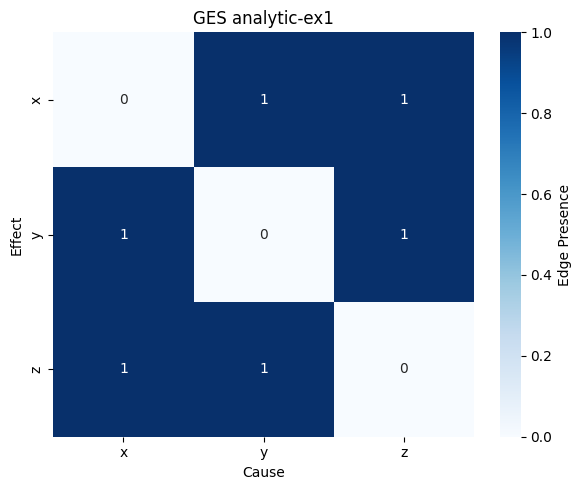


--- Causal Edges in analytic-ex1.dat ---

=== Directed Edges ===
None

=== Undirected Edges ===
x — y
x — z
y — z

=== Bidirectional Edges ===
None

--- Done ---


In [3]:
def compute_causal_graph_single_run(data_matrix, variable_names):
    """Run GES algorithm once and extract directed and undirected edges.

    Args:
        data_matrix (np.ndarray): Input data as a 2D NumPy array where rows are samples and columns are variables.
        variable_names (list[str]): List of variable names corresponding to the columns in data_matrix.

    Returns:
        tuple[list[tuple[str, str]], list[tuple[str, str]]]:
            - directed_edges: List of directed edges in the format (cause, effect).
            - undirected_edges: List of undirected edges in the format (node1, node2) for both directions.
    """
    cg_result = ges(data_matrix)
    cg = cg_result["G"]

    edges_directed = []
    edges_undirected = []

    for edge in cg.get_graph_edges():
        n1_idx = int(edge.get_node1().get_name()[1:]) - 1
        n2_idx = int(edge.get_node2().get_name()[1:]) - 1

        if 0 <= n1_idx < len(variable_names) and 0 <= n2_idx < len(variable_names):
            n1 = variable_names[n1_idx]
            n2 = variable_names[n2_idx]

            ep1, ep2 = edge.get_endpoint1(), edge.get_endpoint2()
            if ep1 == Endpoint.ARROW and ep2 == Endpoint.TAIL:
                edges_directed.append((n1, n2))
            elif ep1 == Endpoint.TAIL and ep2 == Endpoint.ARROW:
                edges_directed.append((n2, n1))
            else:
                # Add both directions for undirected edges
                edges_undirected += [(n1, n2), (n2, n1)]
        else:
            print(f"Warning: Invalid index in edge: {n1_idx}, {n2_idx}")

    return edges_directed, edges_undirected


def create_adjacency_matrix(directed_edges, undirected_edges, node_names):
    """Convert edge lists into an adjacency matrix.

    Args:
        directed_edges (list[tuple[str, str]]): List of directed edges (cause, effect).
        undirected_edges (list[tuple[str, str]]): List of undirected edges (both directions).
        node_names (list[str]): List of all node names.

    Returns:
        np.ndarray: Adjacency matrix where matrix[i, j] = 1 if there is an edge from node i to node j.
    """
    n = len(node_names)
    matrix = np.zeros((n, n))

    for src, tgt in directed_edges:
        if src in node_names and tgt in node_names:
            i, j = node_names.index(src), node_names.index(tgt)
            matrix[i, j] = 1

    for src, tgt in undirected_edges:
        if src in node_names and tgt in node_names:
            i, j = node_names.index(src), node_names.index(tgt)
            matrix[i, j] = matrix[j, i] = 1

    return matrix


def plot_heatmap(matrix, algo_name, var_names, title_suffix=""):
    """Plot a heatmap for the adjacency matrix.

    Args:
        matrix (np.ndarray): Adjacency matrix.
        algo_name (str): Name of the causal discovery algorithm.
        var_names (list[str]): List of variable names.
        title_suffix (str, optional): Suffix to append to the plot title. Defaults to "".
    """
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt=".0f", cmap="Blues",
                xticklabels=var_names, yticklabels=var_names,
                cbar_kws={'label': 'Edge Presence'})
    plt.title(f"{algo_name} {title_suffix}")
    plt.xlabel("Cause")
    plt.ylabel("Effect")
    plt.tight_layout()
    plt.show()
    plt.close()


# === Main Execution ===
file_path = "./dataset/analytic-ex1.dat"
print(f"\n--- Processing dataset: analytic-ex1.dat ---")

data = np.loadtxt(file_path)
var_names = ['x', 'y', 'z']

print("  Running GES...")
directed, undirected = compute_causal_graph_single_run(data, var_names)
print("  GES completed.")

adj_mat = create_adjacency_matrix(directed, undirected, var_names)
plot_heatmap(adj_mat, "GES", var_names, "analytic-ex1")

# === Output Results ===
print(f"\n--- Causal Edges in analytic-ex1.dat ---")

print("\n=== Directed Edges ===")
if directed:
    for edge in sorted(set(directed)):
        print(f"{edge[0]} → {edge[1]}")
else:
    print("None")

print("\n=== Undirected Edges ===")
undirected_only = {tuple(sorted((a, b))) for (a, b) in undirected
                   if (a, b) not in directed and (b, a) not in directed}
if undirected_only:
    for edge in sorted(undirected_only):
        print(f"{edge[0]} — {edge[1]}")
else:
    print("None")

print("\n=== Bidirectional Edges ===")
bidirectional = {tuple(sorted((a, b))) for (a, b) in directed
                 if (b, a) in directed}
if bidirectional:
    for edge in sorted(bidirectional):
        print(f"{edge[0]} ↔ {edge[1]}")
else:
    print("None")

print("\n--- Done ---")

PC Method

Depth=1, working on node 2: 100%|██████████| 3/3 [00:00<00:00, 198.21it/s] 


--- Causal Edges in analytic-ex1.dat ---

=== Directed Edges ===
None

=== Undirected Edges ===
x — y
x — z
y — z

=== Bidirectional Edges ===
None

--- Done ---


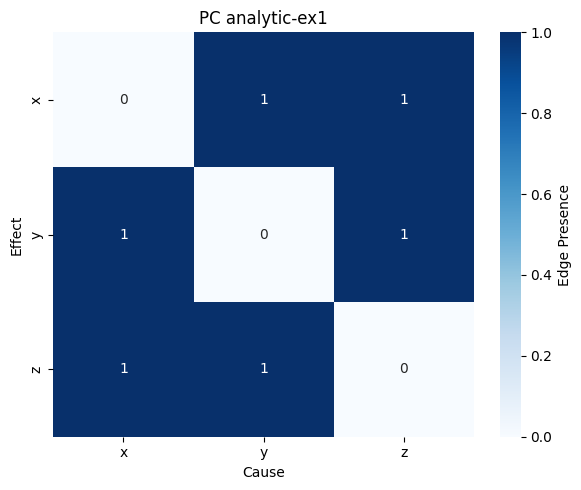

In [3]:
def compute_causal_graph(data, var_names):
    """Run PC algorithm to discover causal structure.

    Args:
        data (np.ndarray): Input data as a 2D NumPy array where rows are samples and columns are variables.
        var_names (list[str]): List of variable names corresponding to the columns in data.

    Returns:
        tuple[list[tuple[str, str]], list[tuple[str, str]]]:
            - directed: List of directed edges (cause, effect).
            - undirected: List of undirected edges (node1, node2) in both directions.
    """
    cg = pc(data, alpha=0.05, indep_test=fisherz)
    directed = []
    undirected = []

    for edge in cg.G.get_graph_edges():
        n1_idx = int(edge.get_node1().get_name()[1:]) - 1
        n2_idx = int(edge.get_node2().get_name()[1:]) - 1
        if n1_idx >= len(var_names) or n2_idx >= len(var_names):
            continue
        n1 = var_names[n1_idx]
        n2 = var_names[n2_idx]

        ep1 = edge.get_endpoint1()
        ep2 = edge.get_endpoint2()

        if ep1 == Endpoint.ARROW and ep2 == Endpoint.TAIL:
            directed.append((n1, n2))
        elif ep1 == Endpoint.TAIL and ep2 == Endpoint.ARROW:
            directed.append((n2, n1))
        else:
            undirected.append((n1, n2))
            undirected.append((n2, n1))

    return directed, undirected


def create_frequency_matrix(directed, undirected, node_names):
    """Create an adjacency frequency matrix from directed and undirected edges.

    Args:
        directed (list[tuple[str, str]]): Directed edges (cause, effect).
        undirected (list[tuple[str, str]]): Undirected edges (both directions).
        node_names (list[str]): List of all node names.

    Returns:
        np.ndarray: Frequency matrix where element (i, j) is the count of edges from node i to node j.
    """
    n = len(node_names)
    mat = np.zeros((n, n), dtype=int)

    for i, j in directed:
        a = node_names.index(i)
        b = node_names.index(j)
        mat[a, b] += 1

    for i, j in undirected:
        a = node_names.index(i)
        b = node_names.index(j)
        mat[a, b] += 1

    return mat


def plot_heatmap(matrix, algo_name, var_names, title_suffix=""):
    """Plot a heatmap for the adjacency or frequency matrix.

    Args:
        matrix (np.ndarray): Adjacency or frequency matrix.
        algo_name (str): Name of the causal discovery algorithm.
        var_names (list[str]): List of variable names.
        title_suffix (str, optional): Suffix to append to the plot title. Defaults to "".
    """
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt=".0f", cmap="Blues",
                xticklabels=var_names, yticklabels=var_names,
                cbar_kws={'label': 'Edge Presence'})
    plt.title(f"{algo_name} {title_suffix}")
    plt.xlabel("Cause")
    plt.ylabel("Effect")
    plt.tight_layout()
    plt.show()
    plt.close()


# === Main Execution ===
file_path = "./dataset/analytic-ex1.dat"
df = pd.read_csv(file_path, header=None, delim_whitespace=True)

# Assign variable names automatically
variable_names = ['x', 'y', 'z']
df.columns = variable_names

data = df.values
directed_edges, undirected_edges = compute_causal_graph(data, variable_names)
matrix = create_frequency_matrix(directed_edges, undirected_edges, variable_names)

# Output results
print(f"--- Causal Edges in {file_path.split('/')[-1]} ---\n")

print("=== Directed Edges ===")
if directed_edges:
    for e in sorted(set(directed_edges)):
        print(f"{e[0]} → {e[1]}")
else:
    print("None")

undir_set = set(frozenset((a, b)) for (a, b) in undirected_edges if a != b)

print("\n=== Undirected Edges ===")
if undir_set:
    for e in sorted(undir_set, key=lambda x: sorted(x)):
        a, b = sorted(e)
        print(f"{a} — {b}")
else:
    print("None")

print("\n=== Bidirectional Edges ===")
bidir = set((a, b) for (a, b) in directed_edges if (b, a) in directed_edges)
if bidir:
    for a, b in sorted(bidir):
        print(f"{a} ↔ {b}")
else:
    print("None")

print("\n--- Done ---")
plot_heatmap(matrix, "PC", variable_names, title_suffix=file_path.split('/')[-1].replace(".dat", ""))


CCM Method


--- Processing dataset: analytic-ex1.dat ---

Potential causal edges (x → y) with rho > 0.2 for analytic-ex1.dat:
x → y (lag=0): rho = 0.977
x → z (lag=0): rho = 0.955
y → x (lag=0): rho = 0.746
y → z (lag=0): rho = 0.979
z → x (lag=0): rho = 0.496
z → y (lag=0): rho = 0.956


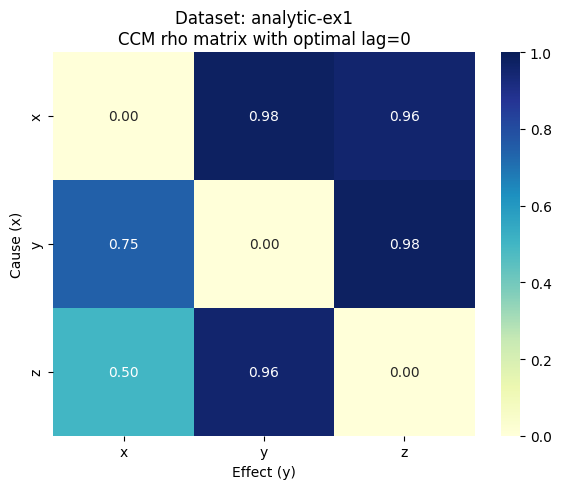

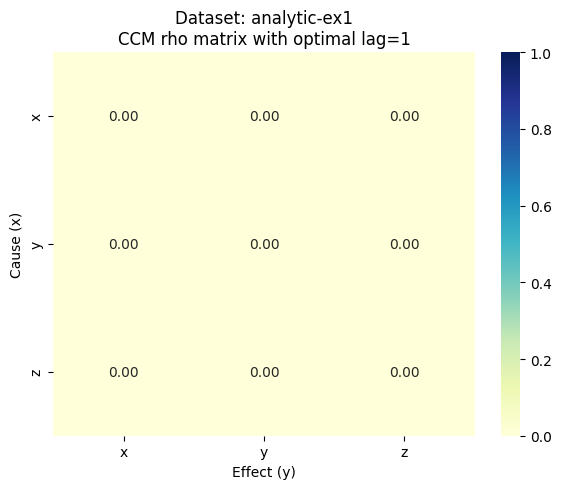

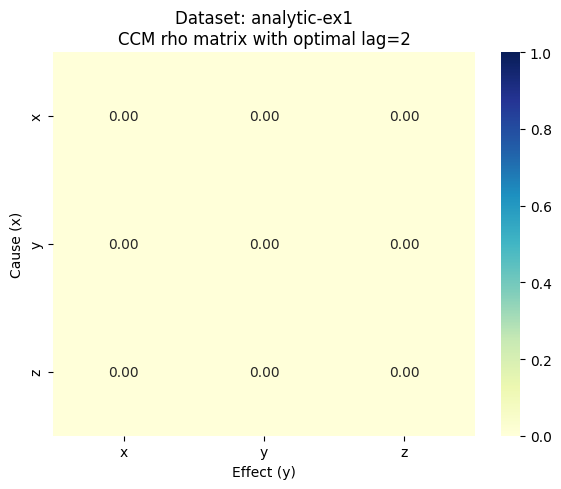

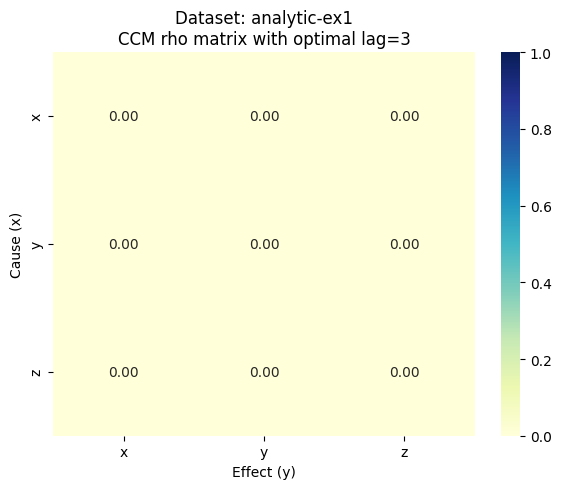

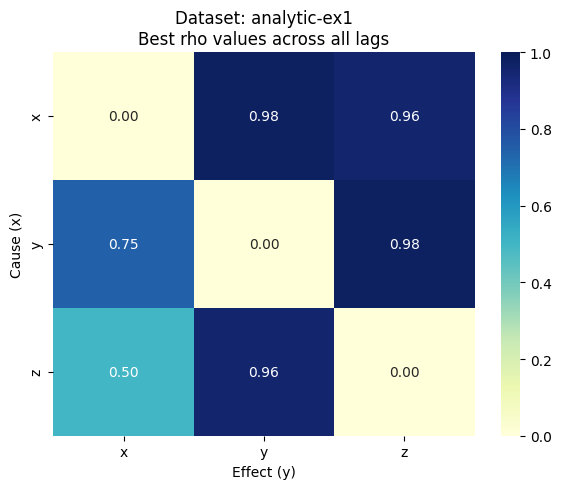


--- Analysis complete! ---


In [5]:
# --- Configuration ---
file_name = os.path.basename(file_path)

# --- Function Definitions ---
def compute_ccm_with_lag(x, y, E=2, libSizes="20 80 20", sample=100, max_lag=3):
    """Compute CCM (Convergent Cross Mapping) with varying lags.

    This function shifts the target time series by different lag values,
    runs the CCM analysis using pyEDM, and returns the rho values for each lag.

    Args:
        x (array-like): Source variable time series.
        y (array-like): Target variable time series.
        E (int, optional): Embedding dimension. Defaults to 2.
        libSizes (str, optional): Library sizes for pyEDM.CCM. Defaults to "20 80 20".
        sample (int, optional): Number of samples for CCM. Defaults to 100.
        max_lag (int, optional): Maximum lag to test. Defaults to 3.

    Returns:
        list[tuple[int, float]]: A list of (lag, rho) pairs for each tested lag.
    """
    results = []
    for lag in range(0, max_lag + 1):
        temp_y_series = pd.Series(y)
        shifted_y = temp_y_series.shift(-lag)

        df_ccm_aligned = pd.DataFrame({
            "time": np.arange(len(x)),
            "x": x,
            "y_shifted": shifted_y
        }).dropna().reset_index(drop=True)

        if df_ccm_aligned.empty:
            rho = np.nan
        else:
            try:
                result = pyEDM.CCM(
                    dataFrame=df_ccm_aligned,
                    E=E,
                    columns="x",
                    target="y_shifted",
                    libSizes=libSizes,
                    sample=sample,
                    embedded=True,
                    showPlot=False
                )
                rho = result["x:y_shifted"].values[-1]
            except Exception as e:
                print(f"Error in pyEDM.CCM for lag {lag}: {e}")
                rho = np.nan

        results.append((lag, rho))
    return results


# --- Load Data ---
print(f"\n--- Processing dataset: {file_name} ---")

# Read .dat file and assign column names
df = pd.read_csv(file_path, sep=r'\s+', header=None)
df.columns = ['x', 'y', 'z']
variables = df.columns.tolist()
n_vars = len(variables)

# Use a subset of the data (1% to 2%)
n = len(df)
start_idx = int(n * 0.01)
end_idx = int(n * 0.02)
df = df.iloc[start_idx:end_idx].reset_index(drop=True)

# --- Main CCM Analysis ---
causal_results = []
max_lag_to_test = 3

for i, j in permutations(range(n_vars), 2):
    source_var = variables[i]
    target_var = variables[j]
    x = df[source_var].values
    y = df[target_var].values

    lag_results = compute_ccm_with_lag(x, y, max_lag=max_lag_to_test)
    valid = [(lag, rho) for lag, rho in lag_results if not np.isnan(rho)]

    if valid:
        best_lag, best_rho = max(valid, key=lambda item: item[1])
    else:
        best_lag, best_rho = np.nan, np.nan

    causal_results.append((source_var, target_var, best_lag, best_rho))

# --- Print Results ---
threshold = 0.2
print(f"\nPotential causal edges (x → y) with rho > {threshold} for {file_name}:")

significant_edges = [
    edge for edge in causal_results
    if not np.isnan(edge[3]) and edge[3] > threshold
]

if significant_edges:
    for source, target, lag, rho in significant_edges:
        print(f"{source} → {target} (lag={int(lag)}): rho = {rho:.3f}")
else:
    print("No significant causal edges found above the threshold.")

# --- Plot Heatmaps for Each Lag ---
for lag in range(0, max_lag_to_test + 1):
    matrix = np.zeros((n_vars, n_vars))
    for source, target, best_lag, rho in causal_results:
        if not np.isnan(rho) and best_lag == lag:
            i = variables.index(source)
            j = variables.index(target)
            matrix[i, j] = rho

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        matrix, annot=True,
        xticklabels=variables, yticklabels=variables,
        cmap="YlGnBu", fmt=".2f", vmin=0, vmax=1
    )
    plt.title(f"Dataset: {file_name.replace('.dat', '')}\n"
              f"CCM rho matrix with optimal lag={lag}")
    plt.xlabel("Effect (y)")
    plt.ylabel("Cause (x)")
    plt.tight_layout()
    plt.show()
    plt.close()

# --- Plot Best Rho Heatmap (All Lags) ---
best_rho_matrix = np.zeros((n_vars, n_vars))
for source, target, best_lag, best_rho in causal_results:
    if not np.isnan(best_rho):
        i = variables.index(source)
        j = variables.index(target)
        best_rho_matrix[i, j] = best_rho

plt.figure(figsize=(6, 5))
sns.heatmap(
    best_rho_matrix, annot=True,
    xticklabels=variables, yticklabels=variables,
    cmap="YlGnBu", fmt=".2f", vmin=0, vmax=1
)
plt.title(f"Dataset: {file_name.replace('.dat', '')}\n"
          f"Best rho values across all lags")
plt.xlabel("Effect (y)")
plt.ylabel("Cause (x)")
plt.tight_layout()
plt.show()
plt.close()

print("\n--- Analysis complete! ---")


Transfer Entropy

In [6]:
# ==== Specify the data file ====
# Define the path to the dataset file to be analyzed.
file_path = "./dataset/analytic-ex1.dat"
file_name = os.path.basename(file_path)

# ==== Check if file exists ====
# Verify that the specified dataset file exists before proceeding.
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

print(f"\nProcessing dataset: {file_name}")

# ==== Load and subsample data ====
# Read the dataset into a DataFrame and select a subset for analysis.
# The subset size is 2% of the total samples, with a minimum of 10 rows.
df = pd.read_csv(file_path, delim_whitespace=True)
n_total = df.shape[0]
n_subset = max(10, int(n_total * 0.02))  
df_sub = df.iloc[:n_subset]

variable_names = df_sub.columns.tolist()
data_array = df_sub.values.T

print(f"Original length: {n_total}, Using first {n_subset} samples ({100*n_subset/n_total:.1f}%)")

# ==== Create Data object ====
# Convert the subset data into a Data object with 'ps' dimension ordering.
data = Data(data_array, dim_order='ps')

# ==== Define fast debug settings ====
# Configure parameters for fast testing, including CMI estimator, lag settings,
# permutation counts, and tau range.
settings = {
    'cmi_estimator': 'JidtKraskovCMI',
    'max_lag_sources': 3,
    'min_lag_sources': 1,
    'verbosity': 0,
    'n_perm_max_stat': 100,
    'n_perm_omnibus': 100,
    'tau_min': 1,
    'tau_max': 1,
}

# ==== Run transfer entropy analysis ====
# Perform multivariate transfer entropy network analysis using the specified settings.
network_analysis = MultivariateTE()
results = network_analysis.analyse_network(settings=settings, data=data)



Processing dataset: analytic-ex1.dat
Original length: 999999, Using first 19999 samples (2.0%)
Adding data with properties: 3 processes, 19999 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2]



    Error importing Cython fast embedding module for HDE estimator.
    When running the HDE estimator, the slow Python implementation for optimizing the HDE embedding will be used,
    this may take a long time. Other estimators are not affected.
    



Target: 0 - testing sources [1, 2]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 100
 -- not significant

No informative sources in the target's past - adding target sample with lag 1.

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3)]
testing candidate: (2, 3) maximum statistic, n_perm: 100
 -- not significant

---------------------------- (3) prune source candidate
no sources selected, nothing to prune ...

---------------------------- (4) final statistics
no sources selected ...
final source samples: []
final target samples: [(0, 1)]



####### analysing target with index 1 from list [0, 1, 2]

Target: 1 - testing sources [0, 2]

---------------------------- (1) include target candidates
candidate set: [(1, 1), (1, 2), (1, 3)]
testing candidate: (1, 3) 
maximum statistic, n_perm: 100
 -- not significant


VARLiNGAM


--- Causal Edges with Strength > 0.1 ---

Lag 0:
y(t-0) → x(t): strength = 27.186
y(t-0) → z(t): strength = -3.192

Lag 1:
No strong causal edges.

Lag 2:
y(t-2) → x(t): strength = -0.115

Lag 3:
No strong causal edges.

Lag 4:
y(t-4) → x(t): strength = -0.118

Lag 5:
No strong causal edges.

Lag 6:
No strong causal edges.

Lag 7:
No strong causal edges.

Lag 8:
No strong causal edges.

Lag 9:
No strong causal edges.

Lag 10:
No strong causal edges.

Lag 11:
No strong causal edges.

Lag 12:
No strong causal edges.

Lag 13:
No strong causal edges.

Lag 14:
No strong causal edges.

Lag 15:
y(t-15) → x(t): strength = -0.110


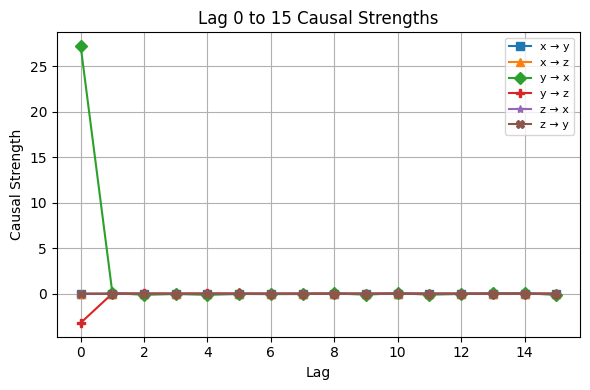

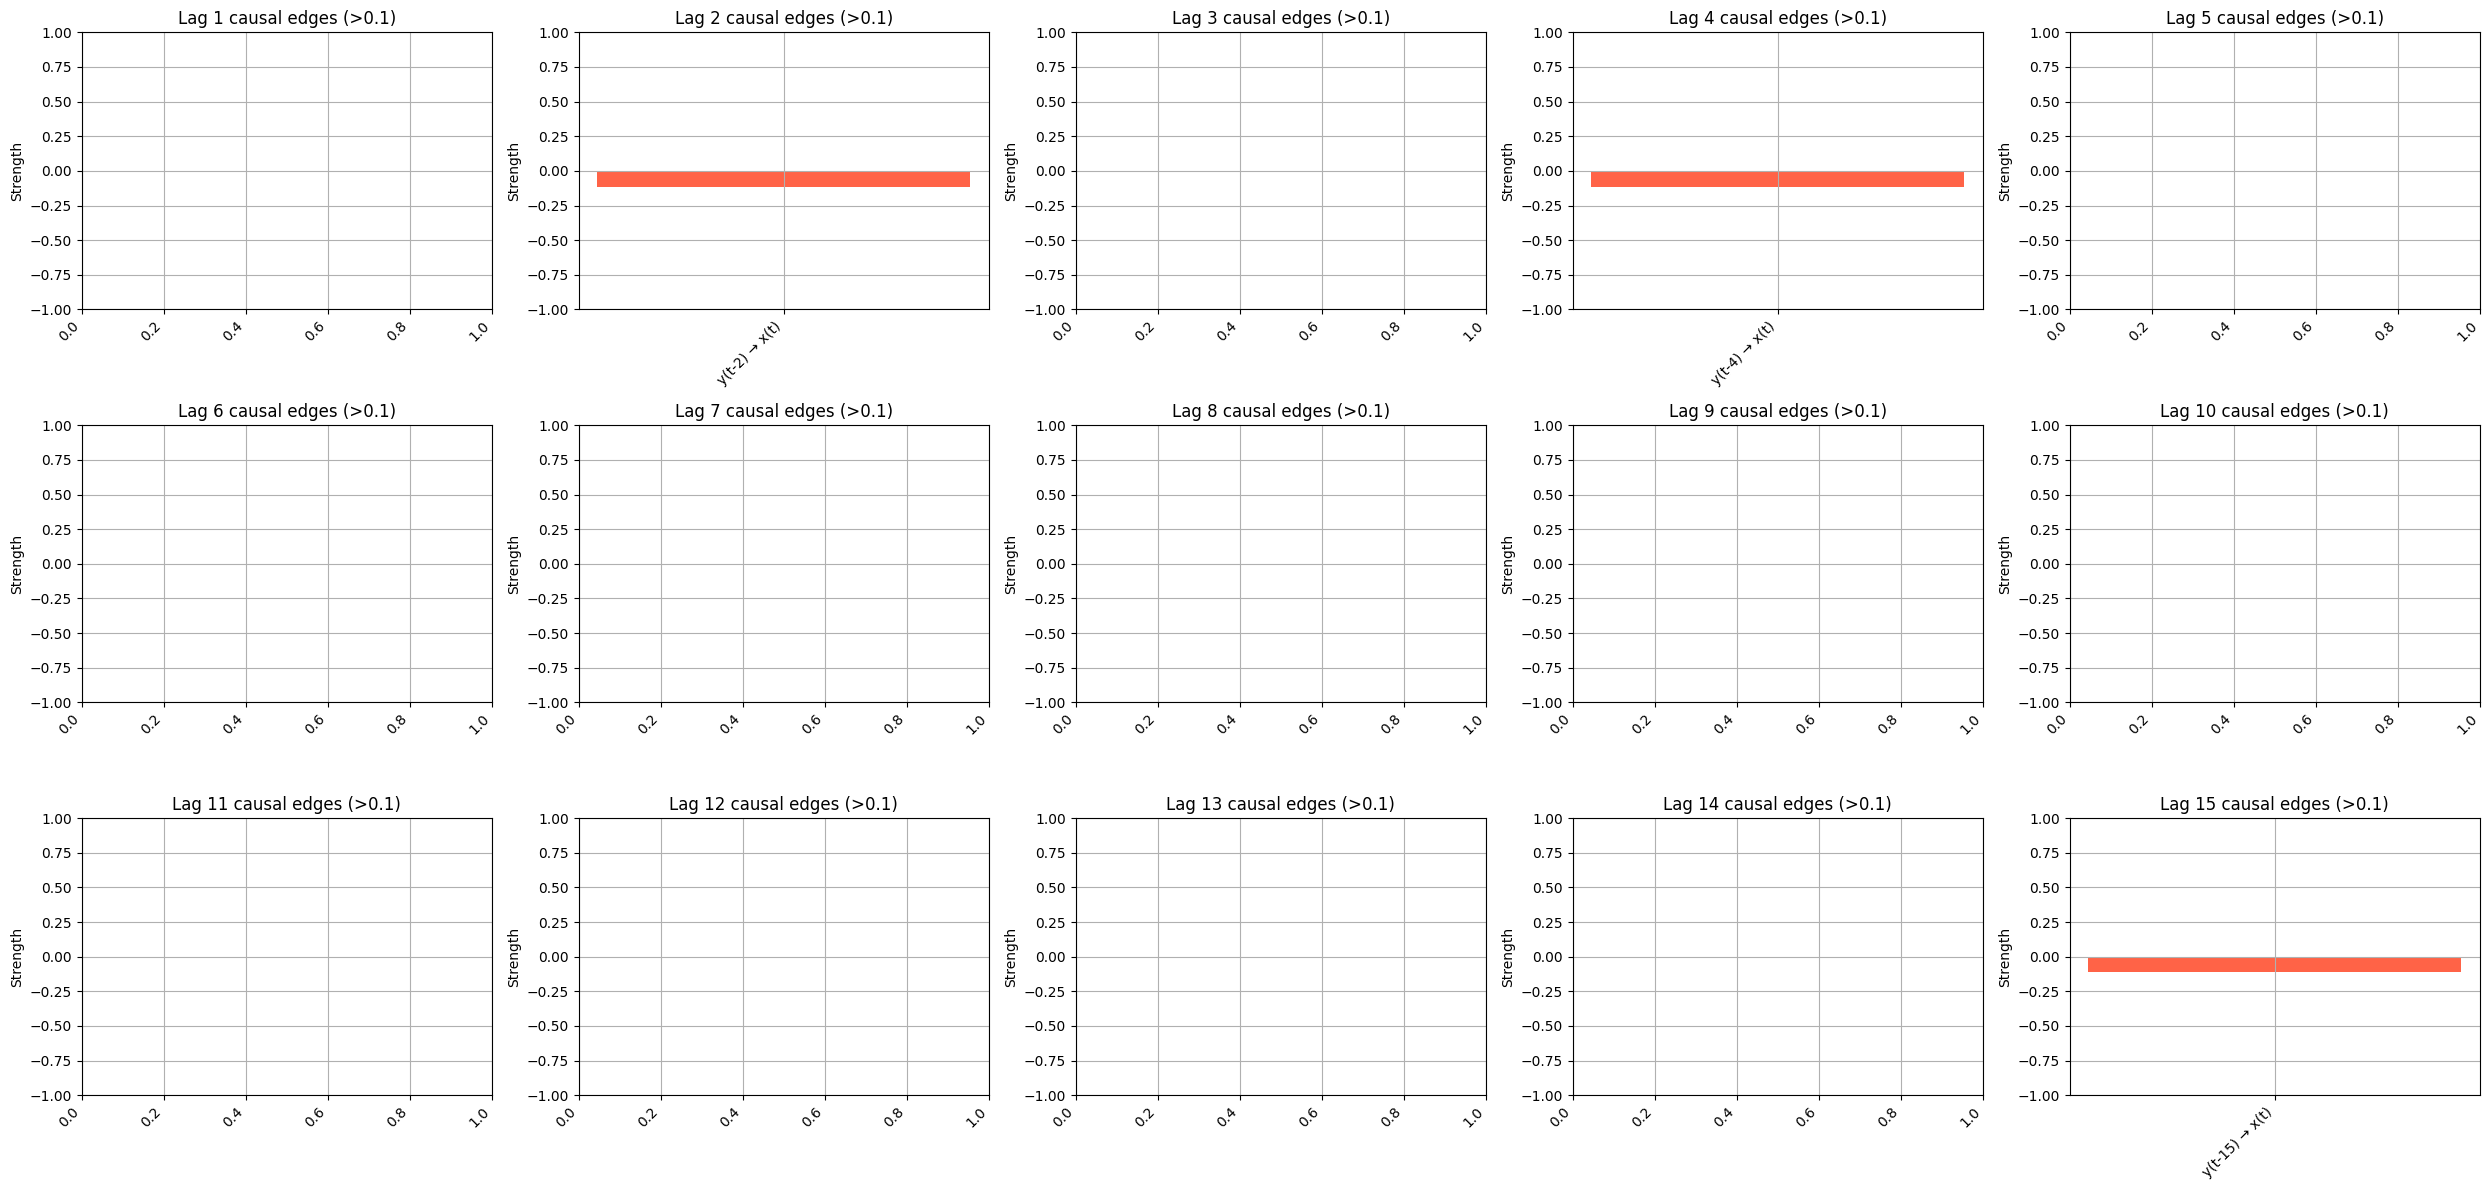

In [6]:
# --- Parameter settings ---
# Define input file, variable names, analysis parameters, and plotting markers.
file_path = "./dataset/analytic-ex1.dat"
var_names = ['x', 'y', 'z']
threshold = 0.1
max_lag = 15
markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', 'h']

# --- Read .dat file ---
# Load the dataset from a .dat file, assign column names, and convert to NumPy array.
df = pd.read_csv(file_path, sep=r'\s+', header=None)
df.columns = var_names
data = df.values
num_vars = data.shape[1]

# --- Fit VARLiNGAM model ---
# Train a VARLiNGAM model with specified maximum lag and settings.
model = VARLiNGAM(lags=max_lag, criterion=None, prune=False, random_state=42)
model.fit(data)

# --- Extract causal strength matrices ---
# Store causal strengths for each variable pair across all lags.
# Note: In adjacency_matrices_, mat[j, i] represents the effect j ← cause i.
causal_strengths = {(i, j): [] for i in range(num_vars) for j in range(num_vars)}
for lag, mat in enumerate(model.adjacency_matrices_):
    for i in range(num_vars):
        for j in range(num_vars):
            causal_strengths[(i, j)].append(mat[j, i])

# --- Print strong causal edges at each lag ---
# Display causal edges whose absolute strength exceeds the threshold.
print(f"\n--- Causal Edges with Strength > {threshold} ---")
for lag in range(max_lag + 1):
    mat = model.adjacency_matrices_[lag]
    print(f"\nLag {lag}:")
    found = False
    for i in range(num_vars):
        for j in range(num_vars):
            strength = mat[j, i]
            if abs(strength) > threshold:
                print(f"{var_names[i]}(t-{lag}) → {var_names[j]}(t): strength = {strength:.3f}")
                found = True
    if not found:
        print("No strong causal edges.")

# --- Plot strength curves from lag=0 to lag=15 ---
# Plot causal strength trajectories for all variable pairs across lags.
plt.figure(figsize=(6, 4))
for idx, ((cause, effect), values) in enumerate(causal_strengths.items()):
    if cause == effect:
        continue  # Skip self-causation
    plt.plot(range(max_lag + 1), values,
             label=f'{var_names[cause]} → {var_names[effect]}',
             marker=markers[idx % len(markers)])
plt.title("Lag 0 to 15 Causal Strengths")
plt.xlabel("Lag")
plt.ylabel("Causal Strength")
plt.grid(True)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

# --- Plot causal bar charts for lag=1 to lag=15 ---
# Create bar plots for strong causal edges at each lag (excluding lag 0).
n_rows = 3
n_cols = 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axs = axs.flatten()

for lag in range(1, max_lag + 1):
    ax = axs[lag - 1]
    mat = model.adjacency_matrices_[lag]
    for i in range(num_vars):
        for j in range(num_vars):
            strength = mat[j, i]
            if abs(strength) > threshold:
                label = f'{var_names[i]}(t-{lag}) → {var_names[j]}(t)'
                ax.bar(label, strength, color='tomato')
    ax.set_title(f"Lag {lag} causal edges (>{threshold})")
    ax.set_ylabel("Strength")
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylim(-1, 1)
    ax.grid(True)

# --- Remove any unused subplots ---
# Delete empty subplots when the grid has more axes than needed.
for i in range(max_lag, len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()
